# Code to make Figure 14
- Decadal map composites over southern Ross Sea for atmosphere variables
- Notebook by Alice DuVivier (NCAR)
- February 2023

In [1]:
import pandas as pd
from minisom import MiniSom, asymptotic_decay
import xarray as xr
import cftime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as cls
from itertools import product
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from datetime import timedelta
from itertools import product
import dask
import utils
import cmocean
import geopandas as gpd

In [2]:
# set the location of the already extracted training data
sector_short = 'Ross'
path_in = '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/analysis/'+sector_short+'_analysis_v4/'
path_out = path_in+'figures_outline/'
# set shape files info
fname= '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/analysis/Ross_analysis_v4/USNIC_ANTARC_shelf_2022/USNIC_ANTARC_shelf_2022.shp' 

### Specify variables to plot

In [3]:
# set path to the pulled data
# Note data is for larger area than only training points
# this data has been processed all the same 'time' coordinates as training data
data_path_in = '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/DATA/data_for_composites/'

# set what variables we can plot
var_in_1= 'SHFLX'
var_in_2= 'LHFLX'

In [4]:
# file name for training variable only here 
fin_1 = 'antarctic_data_for_som_composites_'+var_in_1
fin_2 = 'antarctic_data_for_som_composites_'+var_in_2

In [5]:
# load data
ds_1 = xr.open_mfdataset(data_path_in+fin_1+'.nc')
ds_2 = xr.open_mfdataset(data_path_in+fin_2+'.nc')

In [6]:
# keep just the region of interest
data_1 = ds_1.data.where((ds_1.lon > 140.0) & (ds_1.lon < 230.0) & (ds_1.lat < -68.0))
data_2 = ds_2.data.where((ds_2.lon > 140.0) & (ds_2.lon < 230.0) & (ds_1.lat < -68.0))

In [7]:
# sum both turbulent fluxes to get total turbulent flux
data = data_1 + data_2

In [8]:
# explicitly load data so that it doesn't take forever later on during mean
data = data.load()

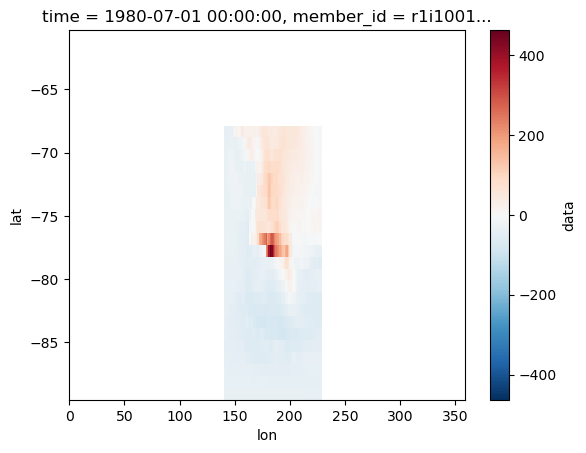

In [9]:
data.isel(training_times=0).plot()

## Calculate the mean for all winter by decade

In [10]:
# calculate winter mean against which to do anomalies
data_mean = data.mean(dim='training_times')

In [11]:
decade_names = ['1980','1990', '2000', '2010', '2020', '2030', '2040', '2050', '2060', '2070']

In [12]:
# make numpy array to fill and specify dimensions we want
decade_array = np.zeros([len(decade_names),len(data_mean.lat),len(data_mean.lon)])

for dd in decade_names:
    print('decade: '+dd+'s')
    if dd == '1980':
        d_count = 0
        yy_st = 1980
    else: 
        d_count = d_count+1
        yy_st = yy_st + 10
    # get years for this decade
    yy_ed = yy_st + 10
    yy_all = list(range(yy_st,yy_ed,1))
    # get mean for this decade
    decade_array[d_count,:,:]   = data.isel(training_times=data.time.dt.year.isin([yy_all])).mean(dim='training_times')
    

decade: 1980s
decade: 1990s
decade: 2000s
decade: 2010s
decade: 2020s
decade: 2030s
decade: 2040s
decade: 2050s
decade: 2060s
decade: 2070s


In [13]:
print(decade_array.shape)

(10, 31, 288)


In [14]:
# convert the numpy array to a xarray for easier plotting
decade_means = xr.DataArray(decade_array,dims=('decade','lat','lon'))

In [15]:
# set coordinate arrays
decade_means['decade'] = decade_names
decade_means['lat'] = data_mean['lat'].values
decade_means['lon'] = data_mean['lon'].values

## Plot decadal mean differences

In [16]:
# Set plotting limits
lat_max = -72
lat_min = -80
lon_max = 200
lon_min = 160
lon_avg = 190

In [17]:
#set shape files info
shdf = gpd.read_file(fname)
# This line is important. Here we convert the projection from the shapefile one to the cartopy one 
shdf = shdf.to_crs(ccrs.SouthPolarStereo())

# Shapefile projection conversion
shdf = gpd.read_file(fname)
shdf = shdf.to_crs(ccrs.SouthPolarStereo(central_longitude=lon_avg))


In [18]:
# set some labeling things
units = '(W $m^{-2}$)'

# set limits
title_in = 'Turbulent Heat Flux'

levels_in = np.arange(-300,325,25)
ticks_in = [-300,-200,-100,0,100,200,300]
cmap_in = cmocean.cm.curl

levels_diff = np.arange(-150,175,25)
ticks_diff = [-100,-50,0,50,100]
cmap_diff = cmocean.cm.diff

# prefixes
pref_1 = 'a) '
pref_2 = 'b) '
pref_3 = 'c) '
  

In [19]:
# bootstrap significance calculation 
# (only should be done for the far right panel; the diffs)

num_iterations = 10000  # this number should be somewhere between 1,000 to 10,000

# create empty array to use for percentile calculation
boot_diff_array = np.zeros((num_iterations, 
                      decade_means.isel(decade=0).shape[0],
                      decade_means.isel(decade=0).shape[1]))

# loop to bootstrap sample array of decades
for i in range(num_iterations):

    ar1 = np.random.choice(np.arange(0,10,1)) # pick random int
    ar2 = np.random.choice(np.arange(0,10,1)) # pick random int
    
    arr1 = 100 * decade_means.isel(decade=ar1) # pick random decade
    arr2 = 100 * decade_means.isel(decade=ar2) # pick random decade
    
    boot_diff_array[i,:,:] = arr1.values - arr2.values  # take diff of random decades

In [22]:
# convert the numpy array to a xarray for calculating
boot_diff = xr.DataArray(boot_diff_array,dims=('nboot','lat','lon'))

# set coordinate arrays
boot_diff['lat'] = decade_means['lat'].values
boot_diff['lon'] = decade_means['lon'].values

In [23]:
# using thresholds, we ask: "did this difference (2070-1980) occur by chance? or is it significant?"
# if it exceeds upper and lower bounds, it is likely that this did not occur by chance

# calculate unique value at all points over all bootstraps
max_thresh_all = boot_diff.quantile(0.975,dim='nboot')
min_thresh_all = boot_diff.quantile(0.025,dim='nboot')


/glade/work/duvivier/miniconda3/envs/geo_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


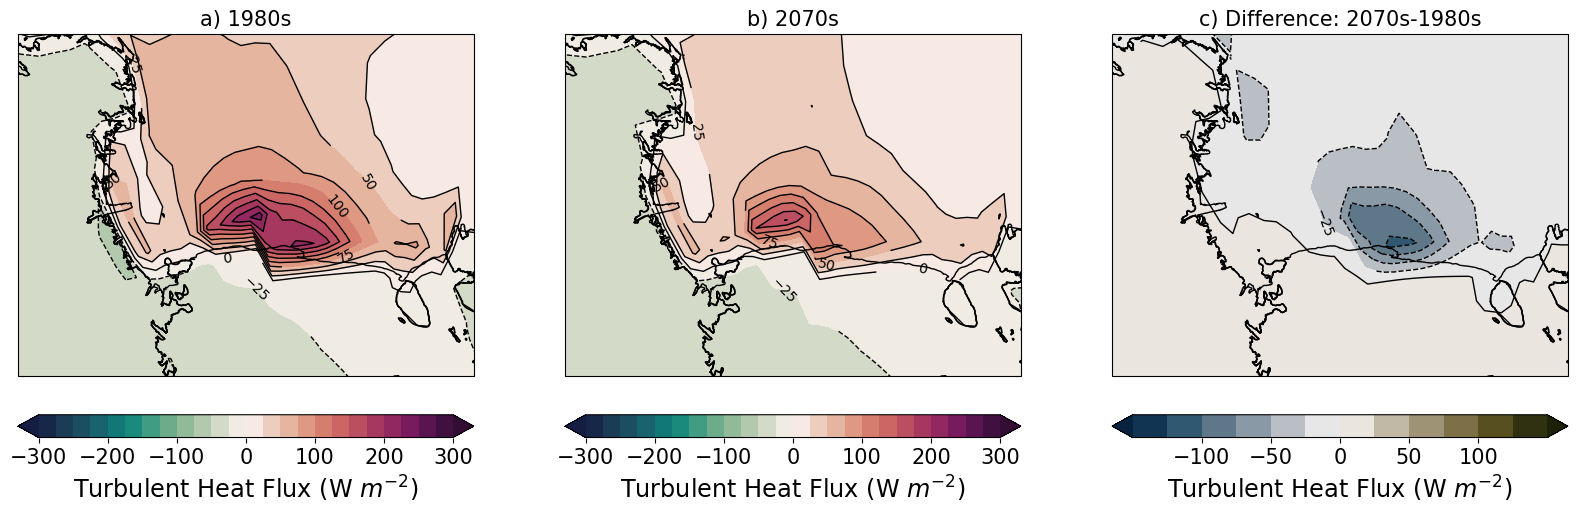

In [25]:
## 2070's difference figure
tag = '2070'

# select data
data_ctrl = decade_means.sel(decade='1980')
data_in = decade_means.sel(decade=tag)
data_diff = data_in - data_ctrl

# keep only data that is significantly different
sig = data_diff.where((data_diff >= max_thresh_all)|(data_diff <= min_thresh_all))
# keep only data that is NOT significancly different because we want to stipple NOT significant points
sig2 = data_diff.where((data_diff <= max_thresh_all)&(data_diff >= min_thresh_all))

# create figure
fig = plt.figure(figsize=(20,10))
fout = path_out+'fig14_decadal_TURBFLX'

# get lats/lons for plotting
lons = ds_1.lon
lats = ds_1.lat

# plot the subplots - note it's nrow x ncol x index (starting upper left)
### mean over 1980s
ax = fig.add_subplot(1,3,1, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
this = ax.contourf(lons,lats,
                   data_ctrl,
                   transform=ccrs.PlateCarree(),
                   cmap = cmap_in,
                   levels=levels_in, extend='both')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_in,label=units,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(title_in+' '+units, fontsize='xx-large')
# overlay contours
this2 = ax.contour(lons,lats,
                   data_ctrl,
                   transform=ccrs.PlateCarree(),
                   colors = 'black', levels = levels_in,linewidths=1)
plt.clabel(this2,colors = 'black', inline=1,fontsize=10,levels=levels_in)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='none')
# Plotting shapefile
ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title(pref_1+'1980s',fontsize=15)

### mean future
ax = fig.add_subplot(1,3,2, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
this = ax.contourf(lons,lats,
                   data_in,
                   transform=ccrs.PlateCarree(),
                   cmap = cmap_in,
                   levels=levels_in, extend='both')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_in,label=units,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(title_in+' '+units, fontsize='xx-large')
# overlay contours
this2 = ax.contour(lons,lats,
                   data_in,
                   transform=ccrs.PlateCarree(),
                   colors = 'black', levels = levels_in,linewidths=1)
plt.clabel(this2,colors = 'black', inline=1,fontsize=10,levels=levels_in)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='none')
# Plotting shapefile
ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title(pref_2+tag+'s',fontsize=15)

### diff
ax = fig.add_subplot(1,3,3, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
this = ax.contourf(lons,lats,
                     data_diff,
                     transform=ccrs.PlateCarree(),
                     cmap = cmap_diff,
                     levels=levels_diff, extend='both')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_diff,label=units,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(title_in+' '+units, fontsize='xx-large')
# overlay contours
this2 = ax.contour(lons,lats,
                   data_diff,
                   transform=ccrs.PlateCarree(),
                   colors = 'black', levels = levels_diff,linewidths=1)
plt.clabel(this2,colors = 'black', inline=1,fontsize=10,levels=levels_diff)
# add significance overtop - stippling where it is NOT significant
#this3 = ax.pcolor(lons,lats,
#                  sig2,
#                  transform=ccrs.PlateCarree(),
#                  hatch='.',
#                  alpha= 0)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='none')
# Plotting shapefile
ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title(pref_3+'Difference: '+tag+'s-1980s',fontsize=15)

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)